### Imports

In [44]:
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# !pip install gym
# !pip install gym-anytrading
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 

# !pip install stable-baselines3
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback

import torch
import quantstats as qs

In [45]:
import yfinance as yf

df = yf.Ticker("GME")
df = df.history(period="max")
df = df.loc['2024-01-01':, :]
# Calculate Moving Averages
df['SMA'] = df['Close'].rolling(window=5).mean()  # Short-term moving average
df['LMA'] = df['Close'].rolling(window=20).mean()  # Long-term moving average

# Calculate RSI
delta = df['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Calculate MACD
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA12'] - df['EMA26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
        
# Handling NaN values that may appear due to the rolling and ewm functions
df.fillna(0, inplace=True)

window_size = 10
start_index = window_size
end_index = len(df)

In [46]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA,LMA,RSI,EMA12,EMA26,MACD,Signal_Line
Date,,,,,,,,,,,,,,
2024-01-02 00:00:00-05:00,17.250000,17.600000,16.580000,16.670000,4428000,0.0,0.0,0.000,0.0000,0.000000,16.670000,16.670000,0.000000,0.000000
2024-01-03 00:00:00-05:00,16.299999,16.830000,15.900000,16.690001,4193600,0.0,0.0,0.000,0.0000,0.000000,16.673077,16.671482,0.001595,0.000319
2024-01-04 00:00:00-05:00,16.510000,16.750000,16.309999,16.360001,2671500,0.0,0.0,0.000,0.0000,0.000000,16.624911,16.648409,-0.023497,-0.004444
2024-01-05 00:00:00-05:00,16.160000,16.520000,15.960000,15.960000,2615700,0.0,0.0,0.000,0.0000,0.000000,16.522617,16.597416,-0.074798,-0.018515
2024-01-08 00:00:00-05:00,15.780000,16.120001,15.700000,15.790000,3031100,0.0,0.0,16.294,0.0000,0.000000,16.409907,16.537607,-0.127700,-0.040352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-15 00:00:00-04:00,10.810000,10.840000,10.060000,10.060000,5086300,0.0,0.0,10.796,12.3055,16.534393,11.389687,12.363404,-0.973717,-0.806445
2024-04-16 00:00:00-04:00,10.000000,10.550000,9.950000,10.370000,4162100,0.0,0.0,10.668,12.1285,15.754333,11.232812,12.215745,-0.982933,-0.841742
2024-04-17 00:00:00-04:00,10.440000,10.590000,10.300000,10.300000,2096700,0.0,0.0,10.558,11.9730,22.562135,11.089302,12.073838,-0.984535,-0.870301


In [47]:
from imp import reload
from gym_anytrading.envs import stocks_env
from gym_anytrading.envs import trading_env

reload(stocks_env)
# reload(trading_env)

<module 'gym_anytrading.envs.stocks_env' from 'C:\\Users\\Steven\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\gym_anytrading\\envs\\stocks_env.py'>

### Create Env

In [48]:
window_size = 10  # Number of past observations the agent can see
frame_bound = (window_size, len(df))

# env = gym.make(
#     'stocks-v0',
#     df=df,
#     window_size=window_size,
#     frame_bound=(start_index, end_index)
# )
env = StocksEnv(df=df, window_size=window_size, frame_bound=frame_bound)
env
print("observation_space:", env.observation_space)

observation_space: Box(-10000000000.0, 10000000000.0, (10, 2), float32)


In [49]:
env_name = 'stocks-v0' 
# # env_name = 'forex-v0'
# env = gym.make(env_name)
# env

env._process_data()

(array([16.67, 16.69, 16.36, 15.96, 15.79, 15.16, 15.73, 15.25, 14.75,
        13.98, 14.08, 14.29, 14.51, 14.9 , 14.18, 13.95, 14.52, 14.49,
        14.78, 14.55, 14.23, 14.42, 14.73, 13.46, 14.1 , 14.07, 14.35,
        14.66, 14.73, 14.17, 14.41, 14.51, 14.12, 13.49, 13.41, 13.36,
        13.51, 13.68, 14.21, 14.24, 14.27, 14.95, 15.22, 15.  , 15.26,
        15.26, 14.65, 14.43, 14.72, 14.87, 14.63, 14.24, 13.91, 13.41,
        13.48, 13.66, 13.1 , 15.12, 15.5 , 13.17, 12.52, 11.99, 11.28,
        11.38, 11.53, 11.25, 10.83, 11.01, 10.85, 11.29, 10.77, 10.06,
        10.37, 10.3 , 10.31, 10.41], dtype=float32),
 array([[ 1.6670000e+01,  0.0000000e+00],
        [ 1.6690001e+01,  2.0000458e-02],
        [ 1.6360001e+01, -3.2999992e-01],
        [ 1.5960000e+01, -4.0000057e-01],
        [ 1.5790000e+01, -1.7000008e-01],
        [ 1.5160000e+01, -6.3000011e-01],
        [ 1.5730000e+01,  5.6999969e-01],
        [ 1.5250000e+01, -4.7999954e-01],
        [ 1.4750000e+01, -5.0000000e-01],
 

In [50]:
print("> signal_features.shape:", env.signal_features.shape)

> signal_features.shape: (76, 2)


In [51]:
env.signal_features

array([[ 1.6670000e+01,  0.0000000e+00],
       [ 1.6690001e+01,  2.0000458e-02],
       [ 1.6360001e+01, -3.2999992e-01],
       [ 1.5960000e+01, -4.0000057e-01],
       [ 1.5790000e+01, -1.7000008e-01],
       [ 1.5160000e+01, -6.3000011e-01],
       [ 1.5730000e+01,  5.6999969e-01],
       [ 1.5250000e+01, -4.7999954e-01],
       [ 1.4750000e+01, -5.0000000e-01],
       [ 1.3980000e+01, -7.7000046e-01],
       [ 1.4080000e+01,  1.0000038e-01],
       [ 1.4290000e+01,  2.1000004e-01],
       [ 1.4510000e+01,  2.2000027e-01],
       [ 1.4900000e+01,  3.8999939e-01],
       [ 1.4180000e+01, -7.1999931e-01],
       [ 1.3950000e+01, -2.3000050e-01],
       [ 1.4520000e+01,  5.7000065e-01],
       [ 1.4490000e+01, -3.0000687e-02],
       [ 1.4780000e+01,  2.8999996e-01],
       [ 1.4550000e+01, -2.2999954e-01],
       [ 1.4230000e+01, -3.2000065e-01],
       [ 1.4420000e+01,  1.9000053e-01],
       [ 1.4730000e+01,  3.0999947e-01],
       [ 1.3460000e+01, -1.2699995e+00],
       [ 1.41000

In [52]:
env.prices

array([16.67, 16.69, 16.36, 15.96, 15.79, 15.16, 15.73, 15.25, 14.75,
       13.98, 14.08, 14.29, 14.51, 14.9 , 14.18, 13.95, 14.52, 14.49,
       14.78, 14.55, 14.23, 14.42, 14.73, 13.46, 14.1 , 14.07, 14.35,
       14.66, 14.73, 14.17, 14.41, 14.51, 14.12, 13.49, 13.41, 13.36,
       13.51, 13.68, 14.21, 14.24, 14.27, 14.95, 15.22, 15.  , 15.26,
       15.26, 14.65, 14.43, 14.72, 14.87, 14.63, 14.24, 13.91, 13.41,
       13.48, 13.66, 13.1 , 15.12, 15.5 , 13.17, 12.52, 11.99, 11.28,
       11.38, 11.53, 11.25, 10.83, 11.01, 10.85, 11.29, 10.77, 10.06,
       10.37, 10.3 , 10.31, 10.41], dtype=float32)

### Define Functions

In [53]:
def print_stats(reward_over_episodes):
    """  Print Reward  """

    avg = np.mean(reward_over_episodes)
    min = np.min(reward_over_episodes)
    max = np.max(reward_over_episodes)

    print (f'Min. Reward          : {min:>10.3f}')
    print (f'Avg. Reward          : {avg:>10.3f}')
    print (f'Max. Reward          : {max:>10.3f}')

    return min, avg, max


# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):
    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


# TRAINING + TEST
def train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps=10_000):
    """ if model=None then execute 'Random actions' """

    # reproduce training and test
    print('-' * 80)
    obs = env.reset(seed=seed)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    vec_env = None

    if model is not None:
        print("model is not None")
        print(f'model {type(model)}')
        print(f'policy {type(model.policy)}')
        # print(f'model.learn(): {total_learning_timesteps} timesteps ...')

        # custom callback for 'progress_bar'
        model.learn(total_timesteps=total_learning_timesteps, callback=ProgressBarCallback(100))
        model.set_random_seed(seed)
        # model.learn(total_timesteps=total_learning_timesteps, progress_bar=True)
        # ImportError: You must install tqdm and rich in order to use the progress bar callback. 
        # It is included if you install stable-baselines with the extra packages: `pip install stable-baselines3[extra]`

        vec_env = model.get_env()
        obs = vec_env.reset()
    else:
        print ("RANDOM actions")

    reward_over_episodes = []

    tbar = tqdm(range(total_num_episodes))

    for episode in tbar:
        
        if vec_env: 
            obs = vec_env.reset()
        else:
            obs, info = env.reset()

        total_reward = 0
        done = False

        while not done:
            if model is not None:
                action, _states = model.predict(obs)
                obs, reward, done, info = vec_env.step(action)
            else: # random
                action = env.action_space.sample()
                obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated

            total_reward += reward
            if done:
                break
            print("total_reward:", total_reward, "reward:", reward)

        reward_over_episodes.append(total_reward)


        if episode % 10 == 0:
            avg_reward = np.mean(reward_over_episodes)
            tbar.set_description(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f}')
            tbar.update()

    tbar.close()
    avg_reward = np.mean(reward_over_episodes)

    return reward_over_episodes

### Train + Test Env

In [54]:
seed = 2023
total_num_episodes = 20

print ("env_name: ", env_name)
print ("seed: ", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# Random actions
model = None 
total_learning_timesteps = 0
rewards = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps)
min, avg, max = print_stats(rewards)
class_name = f'Random actions'
label = f'Avg. {avg:>7.2f} : {class_name}'
plot_data['rnd_rewards'] = rewards
plot_settings['rnd_rewards'] = {'label': label}

learning_timesteps_list_in_K = [25]
# learning_timesteps_list_in_K = [50, 250, 500]
# learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html
model_class_list = [A2C, PPO]
# model_class_list = [PPO]

for timesteps in learning_timesteps_list_in_K:
    total_learning_timesteps = timesteps * 1000  # how many decisions (actions)
    step_key = f'{timesteps}K'
    print('\nstep_key:', step_key)

    for model_class in model_class_list:
        policy_dict = model_class.policy_aliases
        # https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
        # MlpPolicy or MlpLstmPolicy
        policy = policy_dict.get('MlpPolicy')
        if policy is None:
            policy = policy_dict.get('MlpLstmPolicy')
        print ('policy:', policy, 'model_class:', model_class)

        try:
            # # Hyperparameter search space
            # learning_rates = np.linspace(1e-5, 1e-3, 10)
            # clip_ranges = np.linspace(0.1, 0.3, 10)

            # for lr in learning_rates:
            #     for clip in clip_ranges:
            #         model = model_class('MlpPolicy', env, learning_rate=lr, clip_range=clip, verbose=0)
            model = model_class(policy, env, verbose=0)
            class_name = type(model).__qualname__
            plot_key = f'{class_name}_rewards_'+step_key
            rewards = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps)
            print("rewards:", rewards)
            min, avg, max, = print_stats(rewards)
            label = f'Avg. {avg:>7.2f} : {class_name} - {step_key}'
            plot_data[plot_key] = rewards
            plot_settings[plot_key] = {'label': label}     
                   
        except Exception as e:
            print(f"ERROR: {str(e)}")
            continue

env_name:  stocks-v0
seed:  2023
--------------------------------------------------------------------------------
RANDOM actions


Episode: 10, Avg. Reward: -1.310: 100%|██████████| 20/20 [00:00<00:00, 597.82it/s]

total_reward: 0 reward: 0
total_reward: 0 reward: 0
total_reward: 0 reward: 0
total_reward: -0.1099996566772461 reward: -0.1099996566772461
total_reward: -0.1099996566772461 reward: 0
total_reward: -0.1099996566772461 reward: 0
total_reward: -0.1099996566772461 reward: 0
total_reward: -0.1099996566772461 reward: 0
total_reward: -0.1099996566772461 reward: 0
total_reward: -0.1099996566772461 reward: 0
total_reward: -0.1099996566772461 reward: 0
total_reward: -0.1099996566772461 reward: 0
total_reward: -0.1099996566772461 reward: 0
total_reward: -0.1099996566772461 reward: 0
total_reward: -0.1099996566772461 reward: 0
total_reward: -0.1099996566772461 reward: 0
total_reward: -0.1099996566772461 reward: 0
total_reward: -0.1099996566772461 reward: 0
total_reward: -0.1099996566772461 reward: 0
total_reward: -0.1099996566772461 reward: 0
total_reward: 0.17000102996826172 reward: 0.2800006866455078
total_reward: 0.17000102996826172 reward: 0
total_reward: 0.17000102996826172 reward: 0
total_r

### Test Env

In [66]:
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

observation, info = env.reset(seed=2023)

while True:
    # action = env.action_space.sample()
    action, _states = model.predict(observation)

    action_stats[Actions(action)] += 1
    print("action:", action)
    observation, reward, terminated, truncated, info = env.step(action)
    print("reward:", reward)
    done = terminated or truncated

    # env.render()
    if done:
        break

env.close()

print("action_stats:", action_stats)
print("info:", info)

action: 0
reward: 0
action: 1
reward: 0
action: 0
reward: 0.3899993896484375
action: 0
reward: 0
action: 1
reward: 0
action: 1
reward: 0
action: 0
reward: 0.5399999618530273
action: 0
reward: 0
action: 1
reward: 0
action: 1
reward: 0
action: 0
reward: -0.13000011444091797
action: 0
reward: 0
action: 1
reward: 0
action: 0
reward: 0.6400003433227539
action: 1
reward: 0
action: 1
reward: 0
action: 1
reward: 0
action: 1
reward: 0
action: 1
reward: 0
action: 0
reward: 0.3400001525878906
action: 1
reward: 0
action: 0
reward: -0.3900003433227539
action: 1
reward: 0
action: 0
reward: -0.07999992370605469
action: 0
reward: 0
action: 0
reward: 0
action: 1
reward: 0
action: 1
reward: 0
action: 1
reward: 0
action: 0
reward: 0.5900001525878906
action: 1
reward: 0
action: 0
reward: 0.2700004577636719
action: 0
reward: 0
action: 0
reward: 0
action: 1
reward: 0
action: 1
reward: 0
action: 1
reward: 0
action: 0
reward: -0.5399999618530273
action: 0
reward: 0
action: 1
reward: 0
action: 1
reward: 0
acti

### Plot Results

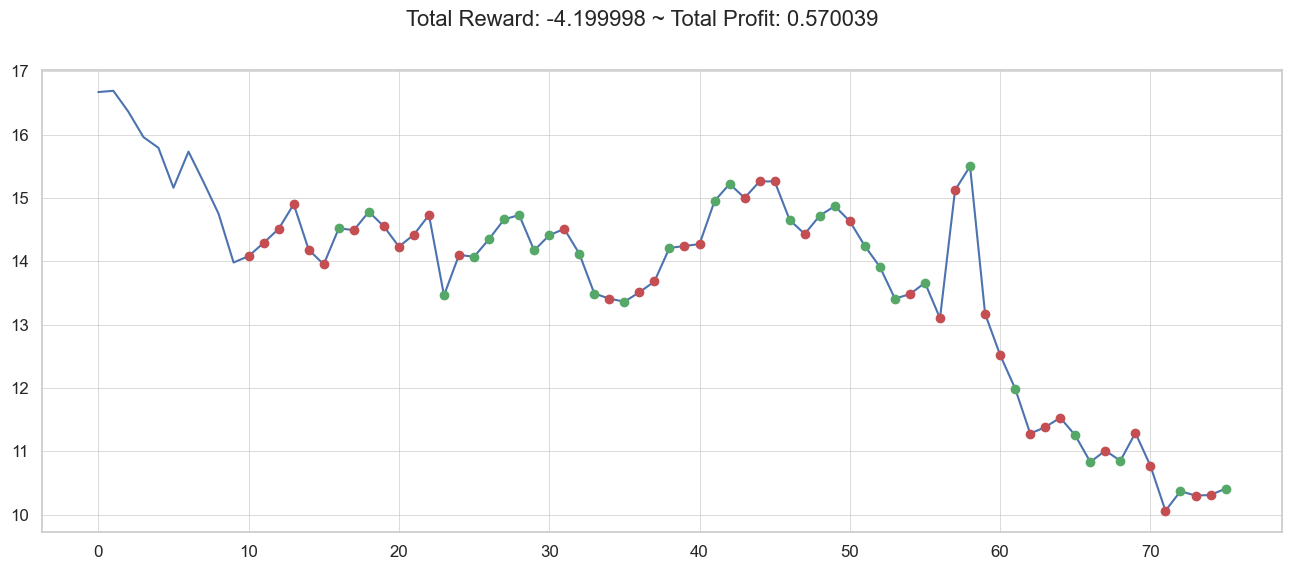

In [56]:
plt.figure(figsize=(16, 6))
env.unwrapped.render_all()
plt.show()

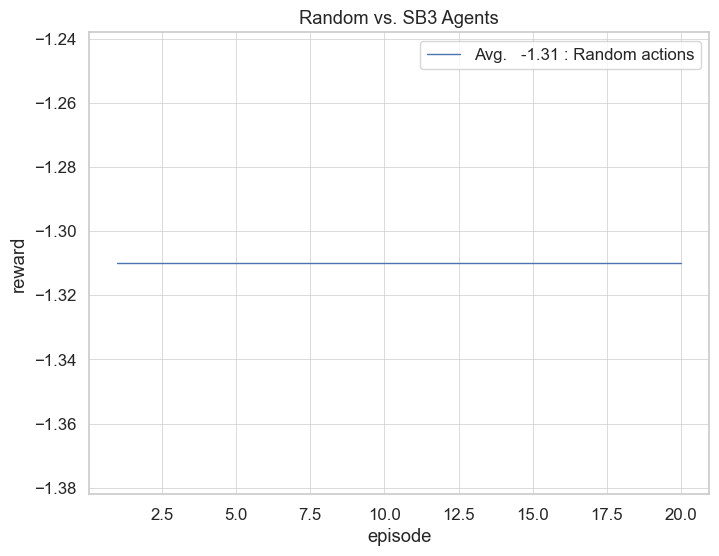

In [57]:
data = pd.DataFrame(plot_data)

sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))

for key in plot_data:
    if key == 'x':
        continue
    label = plot_settings[key]['label']
    line = plt.plot('x', key, data=data, linewidth=1, label=label)

plt.xlabel('episode')
plt.ylabel('reward')
plt.title('Random vs. SB3 Agents')
plt.legend()
plt.show()

In [58]:
len(env.unwrapped.history['total_profit'])

65

                           Strategy
-------------------------  ----------
Start Period               2024-01-19
End Period                 2024-04-19
Risk-Free Rate             0.0%
Time in Market             27.0%

Cumulative Return          -43.0%
CAGR﹪                     -78.91%

Sharpe                     -4.92
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -4.46
Sortino                    -4.83
Smart Sortino              -4.38
Sortino/√2                 -3.41
Smart Sortino/√2           -3.09
Omega                      0.12

Max Drawdown               -43.16%
Longest DD Days            85
Volatility (ann.)          42.78%
Calmar                     -1.83
Skew                       -3.65
Kurtosis                   17.46

Expected Daily %           -0.87%
Expected Monthly %         -13.11%
Expected Yearly %          -43.0%
Kelly Criterion            -129.76%
Risk of Ruin               0.0%
Daily Value-at-Risk        -5.27%
Expected Shortfall (cVaR)  -5.27%

Max Consecuti

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-01-26,2024-04-09,2024-04-19,84,-43.158523,-42.996099


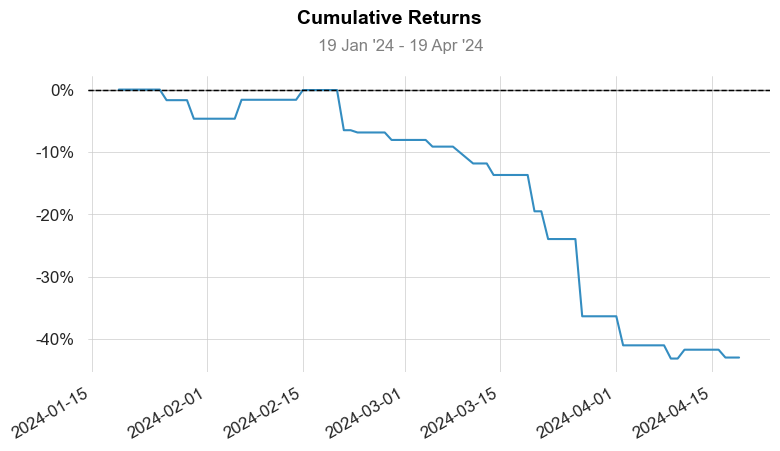

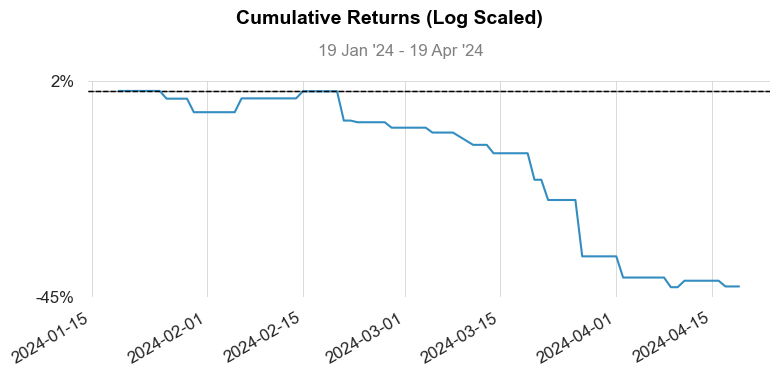

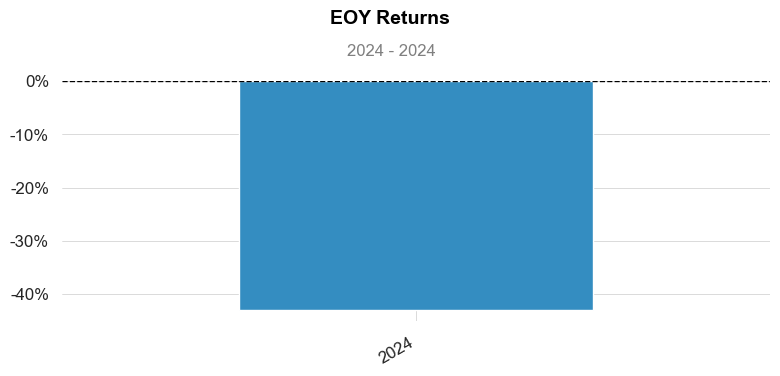

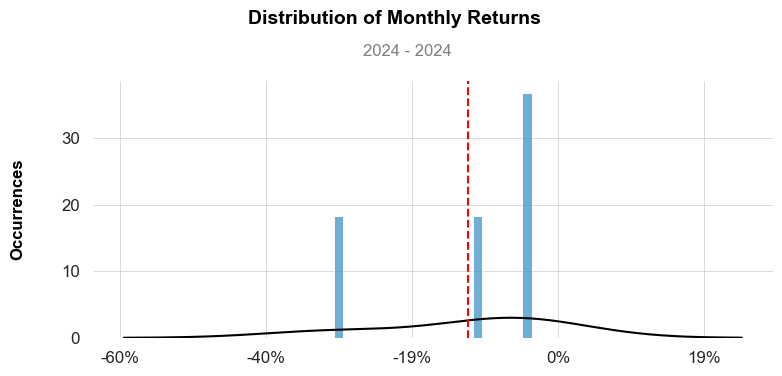

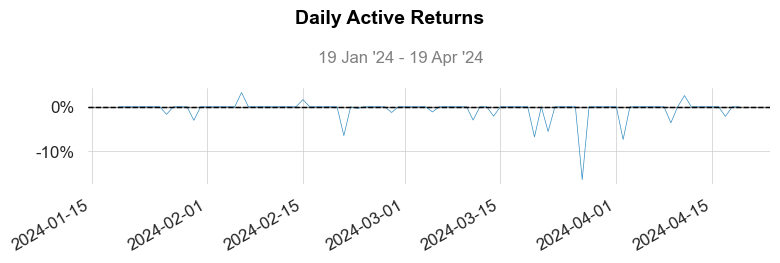

IndexError: index 0 is out of bounds for axis 0 with size 0

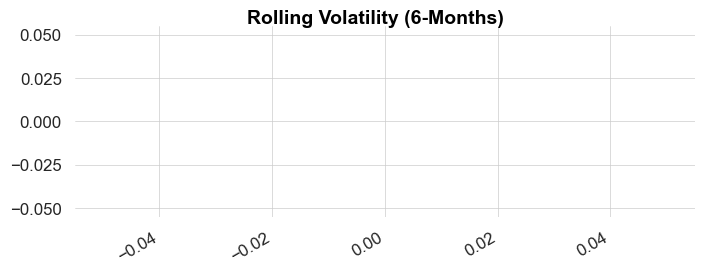

In [59]:
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output='SB3_a2c_quantstats.html')